In [13]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### SAFE TIFF READER

In [14]:
def read_tif(path, size=(128,128)):
    """Read single-channel TIFF and normalize to [0,1]"""
    with rasterio.open(path) as src:
        img = src.read(1)
    img = cv2.resize(img, size)
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)
    return img

### DATASET CLASS

In [15]:
class CropDataset(Dataset):
    def __init__(self, base_dir):
        self.ndvi_dir = os.path.join(base_dir, "NDVI")
        self.rgb_dir  = os.path.join(base_dir, "RGB")
        self.vh_dir   = os.path.join(base_dir, "SAR", "VH")
        self.vv_dir   = os.path.join(base_dir, "SAR", "VV")

        # Keep only aligned filenames
        self.files = sorted(
            set(os.listdir(self.ndvi_dir)) &
            set(os.listdir(self.rgb_dir)) &
            set(os.listdir(self.vh_dir)) &
            set(os.listdir(self.vv_dir))
        )
        print("Total aligned samples:", len(self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]

        # RGB
        rgb = cv2.imread(os.path.join(self.rgb_dir, name))
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        rgb = cv2.resize(rgb, (128,128))
        rgb = rgb.astype(np.float32) / 255.0

        # NDVI + SAR
        ndvi = read_tif(os.path.join(self.ndvi_dir, name))
        vh   = read_tif(os.path.join(self.vh_dir, name))
        vv   = read_tif(os.path.join(self.vv_dir, name))

        # Add channel dimension
        ndvi = ndvi[..., None]
        vh   = vh[..., None]
        vv   = vv[..., None]

        # Concatenate all channels → (H,W,6)
        image = np.concatenate([rgb, ndvi, vh, vv], axis=2)
        return image, name

### LOAD DATA

In [16]:
base_dir = r"E:\Early Crop Stress Prediction Before Visible Damage\Dataset"
dataset = CropDataset(base_dir)
loader = DataLoader(dataset, batch_size=16, shuffle=False)

Total aligned samples: 2200


### REAL-WORLD THRESHOLDS FOR PSEUDO-LABELING

In [17]:
NDVI_THRESHOLD = 0.5
VH_DB_THRESHOLD = -12
VV_DB_THRESHOLD = -8

def db_to_norm(val, min_db=-25, max_db=0):
    return (val - min_db) / (max_db - min_db)

VH_THRESHOLD = db_to_norm(VH_DB_THRESHOLD)
VV_THRESHOLD = db_to_norm(VV_DB_THRESHOLD)

### COMPUTE ExG FUNCTION

In [18]:
def compute_exg(rgb_img):
    """
    rgb_img: H x W x 3, normalized [0,1]
    Returns: average ExG for the image
    """
    R = rgb_img[:,:,0]
    G = rgb_img[:,:,1]
    B = rgb_img[:,:,2]
    exg = 2*G - R - B
    return np.mean(exg)

### COLLECT IMAGES AND PSEUDO-LABELS

In [19]:
all_images = []
file_names = []
pseudo_labels = []

for batch in loader:
    images, names = batch
    images = images.numpy()
    for i in range(images.shape[0]):
        img = images[i]
        all_images.append(img)
        file_names.append(names[i])

        # Extract channels
        ndvi = img[:,:,3]
        vh   = img[:,:,4]
        vv   = img[:,:,5]

        # Pseudo-label: 1 = stressed, 0 = healthy
        score = 0
        if ndvi.mean() < NDVI_THRESHOLD: score += 1
        if vh.mean()   < VH_THRESHOLD:   score += 1
        if vv.mean()   < VV_THRESHOLD:   score += 1
        label = 1 if score >= 2 else 0
        pseudo_labels.append(label)

c:\Users\vishm\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


### COMPUTE ExG DISTRIBUTIONS SEPARATELY

In [20]:
exg_healthy = []
exg_stressed = []

for i, img in enumerate(all_images):
    rgb = img[:,:,0:3]
    avg_exg = compute_exg(rgb)
    
    if pseudo_labels[i] == 0:
        exg_healthy.append(avg_exg)
    else:
        exg_stressed.append(avg_exg)

exg_healthy = np.array(exg_healthy)
exg_stressed = np.array(exg_stressed)

print("Healthy crops ExG stats:")
print(f"Mean: {exg_healthy.mean():.4f}, Std: {exg_healthy.std():.4f}, Min: {exg_healthy.min():.4f}, Max: {exg_healthy.max():.4f}")

print("Stressed crops ExG stats:")
print(f"Mean: {exg_stressed.mean():.4f}, Std: {exg_stressed.std():.4f}, Min: {exg_stressed.min():.4f}, Max: {exg_stressed.max():.4f}")

Healthy crops ExG stats:
Mean: 0.0951, Std: 0.0414, Min: -0.0760, Max: 0.2812
Stressed crops ExG stats:
Mean: 0.0609, Std: 0.0528, Min: -0.0770, Max: 0.2929


### VISUALIZE ExG DISTRIBUTIONS

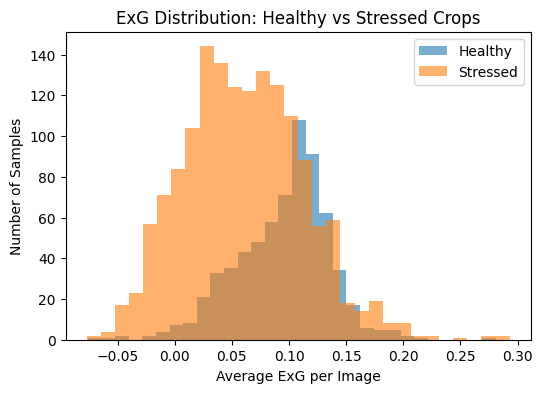

In [21]:
plt.figure(figsize=(6,4))
plt.hist(exg_healthy, bins=30, alpha=0.6, label="Healthy")
plt.hist(exg_stressed, bins=30, alpha=0.6, label="Stressed")
plt.xlabel("Average ExG per Image")
plt.ylabel("Number of Samples")
plt.title("ExG Distribution: Healthy vs Stressed Crops")
plt.legend()
plt.show()

### SAVE PSEUDO-LABELS AND ExG

In [22]:
df = pd.DataFrame({
    "image": file_names,
    "pseudo_label": pseudo_labels,
    "avg_exg": [compute_exg(img[:,:,0:3]) for img in all_images]
})
df.to_csv("pseudo_labels_with_exg.csv", index=False)
print("Saved pseudo_labels_with_exg.csv")

unique, counts = np.unique(pseudo_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")

Saved pseudo_labels_with_exg.csv
Label 0: 666 samples
Label 1: 1534 samples


### COMPUTE SILHOUETTE AND DAVIES-BOULDIN SCORE

In [23]:
features = []

for img in all_images:
    ndvi = img[:,:,3].mean()
    vh   = img[:,:,4].mean()
    vv   = img[:,:,5].mean()
    exg  = compute_exg(img[:,:,0:3])
    features.append([ndvi, vh, vv, exg])

features = np.array(features)
labels = pseudo_labels  # your clusters

score = silhouette_score(features, labels)
print("Silhouette Score:", score)

db_index = davies_bouldin_score(features, labels)
print("Davies-Bouldin Index:", db_index)

Silhouette Score: 0.25239843130111694
Davies-Bouldin Index: 1.1510734621064278


###  PCA 2D VISUALIZATION

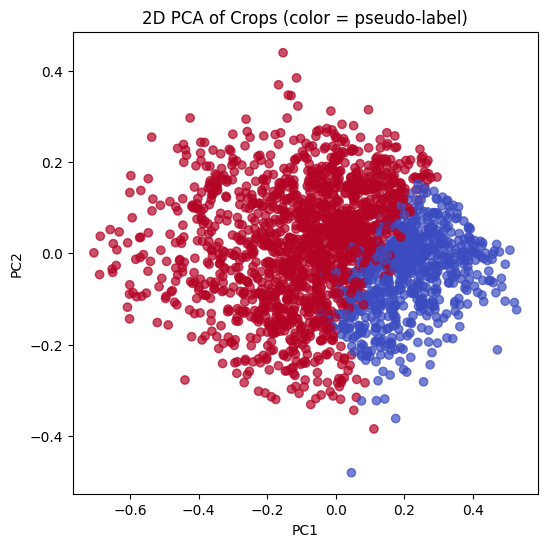

In [24]:
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.figure(figsize=(6,6))
plt.scatter(features_2d[:,0], features_2d[:,1], c=labels, cmap='coolwarm', alpha=0.7)
plt.title("2D PCA of Crops (color = pseudo-label)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### KMeans CLUSTERING

KMeans Silhouette Score: 0.36559510231018066
KMeans Davies-Bouldin Index: 1.0450200571273551


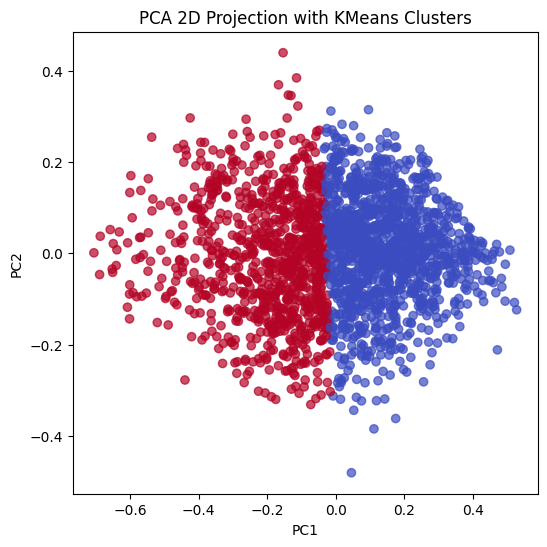

In [25]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(features)

# Evaluate clusters
sil_score = silhouette_score(features, kmeans_labels)
db_index  = davies_bouldin_score(features, kmeans_labels)

print("KMeans Silhouette Score:", sil_score)
print("KMeans Davies-Bouldin Index:", db_index)

# PCA 2D visualization of KMeans clusters
plt.figure(figsize=(6,6))
plt.scatter(features_2d[:,0], features_2d[:,1], c=kmeans_labels, cmap='coolwarm', alpha=0.7)
plt.title("PCA 2D Projection with KMeans Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### ALIGN KMEANS CLUSTER IDS WITH PSEUDO-LABELS

In [26]:
cluster0_healthy_count = np.sum(np.array(pseudo_labels)[np.array(kmeans_labels)==0] == 0)
cluster1_healthy_count = np.sum(np.array(pseudo_labels)[np.array(kmeans_labels)==1] == 0)

if cluster1_healthy_count > cluster0_healthy_count:
    kmeans_labels = 1 - np.array(kmeans_labels)  # swap 0 ↔ 1

### COMPARE CLUSTERS WITH PSEUDO-LABELS

In [27]:
matches = np.array(pseudo_labels) == np.array(kmeans_labels)
accuracy = np.sum(matches) / len(matches)

print(f"Agreement between KMeans clusters and threshold pseudo-labels: {accuracy*100:.2f}%")


Agreement between KMeans clusters and threshold pseudo-labels: 72.00%


### SAVE COMPARISON

In [28]:
df_compare = pd.DataFrame({
    "image": file_names,
    "pseudo_label": pseudo_labels,
    "kmeans_label": kmeans_labels,
    "match": matches
})
df_compare.to_csv("compare_kmeans_threshold.csv", index=False)
print("Saved compare_kmeans_threshold.csv")

Saved compare_kmeans_threshold.csv


###  VISUALIZE SAMPLES

c:\Users\vishm\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


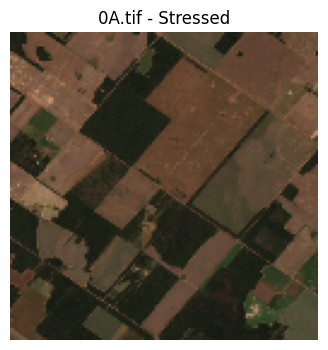

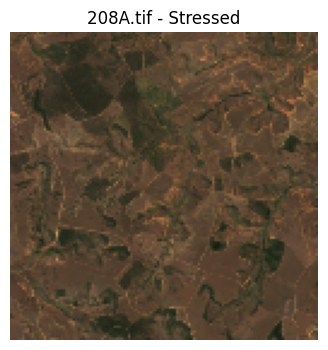

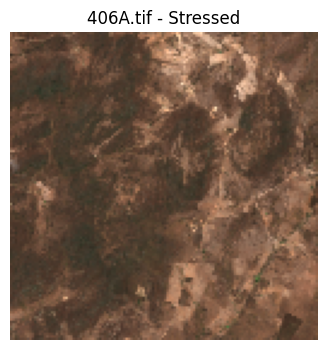

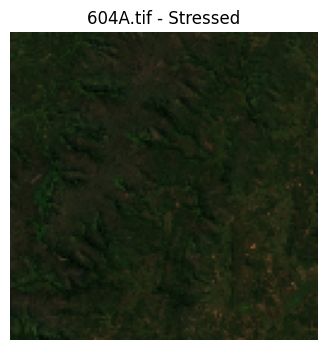

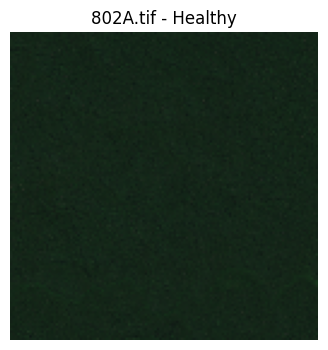

In [29]:
for i in range(0, len(dataset), max(1, len(dataset)//5)):  # show 5 samples
    img, name = dataset[i]
    label = pseudo_labels[i]
    plt.figure(figsize=(4,4))
    plt.imshow(img[:,:,0:3])
    plt.title(f"{name} - {'Healthy' if label==0 else 'Stressed'}")
    plt.axis('off')
    plt.show()
